In [48]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
enfo_data = pd.read_table('gs://korvaz/mpra_model_manuscript/data/enformer__mpra_test_set_preds.csv', sep='\t', header=0)
mpra_data = pd.read_table('gs://korvaz/mpra_model_manuscript/data/boda2__single_variant_pairs__raw.txt', sep=' ', header=0)
mpra_data.set_index('IDs_ref', inplace=True)

In [15]:
mpra_data = pd.read_table('gs://korvaz/mpra_model_manuscript/data/boda2__single_variant_pairs__raw.txt', sep=' ', header=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: DtypeWarning: Columns (10,48) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
k562_tags = [ tag for tag in data.columns if 'K562' in tag ]
k562_flags= [ 'K562' in tag for tag in enfo_data.columns ]

In [8]:
k562_tags

['33_DNASE:K562 treated w',
 '34_DNASE:K562 G2 phase',
 '35_DNASE:K562 G1 phase',
 '121_DNASE:K562',
 '122_DNASE:K562',
 '123_DNASE:K562',
 '625_DNASE:K562',
 '697_CHIP:CTCF:K562',
 '698_CHIP:H3K27me3:K562',
 '699_CHIP:H3K36me3:K562',
 '700_CHIP:H3K4me2:K562',
 '701_CHIP:H3K4me3:K562',
 '702_CHIP:H3K9ac:K562',
 '703_CHIP:H3K9me1:K562',
 '760_CHIP:H2AFZ:K562',
 '761_CHIP:H3K79me2:K562',
 '762_CHIP:H3K9me3:K562',
 '774_CHIP:KDM5B:K562',
 '776_CHIP:HDAC1:K562',
 '777_CHIP:HDAC2:K562',
 '778_CHIP:PHF8:K562',
 '779_CHIP:RBBP5:K562',
 '780_CHIP:SAP30:K562',
 '834_CHIP:HDAC6:K562',
 '841_CHIP:CREBBP:K562',
 '842_CHIP:CBX3:K562',
 '843_CHIP:KAT2B:K562',
 '844_CHIP:SIRT6:K562',
 '845_CHIP:SUZ12:K562',
 '856_CHIP:SETDB1:K562',
 '863_CHIP:WHSC1:K562',
 '946_CHIP:BCLAF1:K562',
 '951_CHIP:ETS1:K562',
 '958_CHIP:E2F6:K562',
 '960_CHIP:GABPA:K562',
 '961_CHIP:MAX:K562',
 '962_CHIP:SIN3A:K562',
 '971_CHIP:ZBTB7A:K562',
 '973_CHIP:YY1:K562',
 '979_CHIP:POLR2A:K562',
 '981_CHIP:FOSL1:K562',
 '982_CHIP:R

In [12]:
strict_k562_filter = k562_tags[3:7]
full_filter = list(enfo_data.columns[0:5]) + list(strict_k562_filter)
k562_dnase_flags = [ tag in full_filter for tag in enfo_data.columns ]

In [37]:
merged_data = pd.concat(
    [
        enfo_data.loc[:, k562_dnase_flags].set_index('id'), 
        mpra_data.loc[:,['K562_mean_alt','K562_mean_ref','K562_pred_aggreg_alt','K562_pred_aggreg_ref']]
    ],axis=1,join='inner'
)

(0.02782686005767095, 1.6743955424170807e-06)


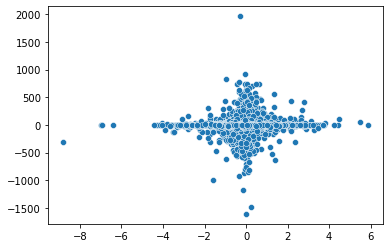

In [53]:
print(
    pearsonr(
        merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
        merged_data.loc[:,strict_k562_filter].mean(axis=1)
    )
)

sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y= merged_data.loc[:,strict_k562_filter].mean(axis=1)
)
plt.show()

(0.33627985950346845, 0.0)


<AxesSubplot:>

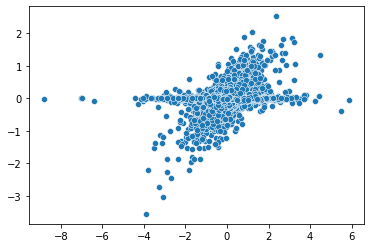

In [54]:
print(
    pearsonr(
        merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
        merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref']
    )
)

sns.scatterplot( 
    x=merged_data.loc[:,'K562_mean_alt'] - merged_data.loc[:,'K562_mean_ref'],
    y=merged_data.loc[:,'K562_pred_aggreg_alt'] - merged_data.loc[:,'K562_pred_aggreg_ref']
)

In [42]:
merged_data.loc[:,strict_k562_filter].mean(axis=1)

13:100002396:G:A:R:wC      -2.200189
13:100002818:G:C:R:wC      -3.958167
13:100005697:C:A:R:wC       0.645617
13:100005985:C:CA:R:wC   -154.497698
13:100011671:A:T:R:wC      -2.102854
                             ...    
7:99983135:C:T:R:wC        -8.821835
7:99984089:T:C:R:wC       -15.045293
7:9998677:C:G:R:wC          0.573241
7:99990364:T:G:R:wC         3.690922
7:99994813:A:G:R:wC        -2.519956
Length: 29612, dtype: float64

In [52]:
merged_data.isna().sum()

chrom                   0
pos                     0
ref                     0
alt                     0
121_DNASE:K562          0
122_DNASE:K562          0
123_DNASE:K562          0
625_DNASE:K562          0
K562_mean_alt           0
K562_mean_ref           0
K562_pred_aggreg_alt    0
K562_pred_aggreg_ref    0
dtype: int64